# Imports

In [1]:
using Random
using Statistics
using Distributions
using ShiftedArrays
using CategoricalArrays
# using StatsPlots
using HypothesisTests

using DataFrames
using DataFramesMeta
using SpecialFunctions
using LinearAlgebra
using StatsFuns
using MixedModels
using CodecZlib
using JLD2
using Serialization
using LaTeXStrings

using CairoMakie  
# CairoMakie.activate!(inline=true)
CairoMakie.activate!(type = "png", inline=true, px_per_unit=2.0, pt_per_unit=1.0)

┌ Warning: This version of Mods is still under development. Don't upgrade to version 2.0.x yet. I'm working on it.
└ @ Mods /Users/ari/.julia/packages/Mods/zl9ID/src/Mods.jl:5


In [5]:
using RLSR
using EM
include("../code/em_scripts.jl")
include("../code/sailing_base_lrl_blockwise_twoλ.jl");

In [6]:
set_theme!()
update_theme!(
        fontsize = 7,
        fonts = (; regular= "Helvetica", bold="Helvetica"),
        figure_padding = (5.0, 5.0, 5.0, 5.0),
        Lines = (
            linewidth = 1.0,
        )
    )


In [8]:
file_prefix = "blockwise"
full_df = load("../derived/$(file_prefix).jld2")["full_df"]
ntrials = maximum(full_df.trial)
full_df[1:5, :]

Row,state1,state2,state3,endState,endBranchLeft,reward,action1Left,action2Left,rewardₜ₋₁,rewardₜ₋₂,state1ₜ₋₁,state1ₜ₋₂,state1ₜ₋₃,state2ₜ₋₁,state2ₜ₋₂,state3ₜ₋₁,state3ₜ₋₂,endStateₜ₋₁,endStateₜ₋₂,endBranchLeftₜ₋₁,endBranchLeftₜ₋₂,trial,subject,action1TowardsPrevEnd,action1Persistance,endBranchₜ₋₁SameAsLastChoice,priorMoveAt1,priorMoveAt2,priorMoveAt3,parentPriorMove,parentPriorMoveToEndState,parentPriorMoveToEndStateₜ₋₁,priorRewardAt2,priorRewardAt3,priorRewardAt4,priorRewardAt5,priorRewardAt6,priorRewardAt7,endStateSiblingPriorReward,endStateSiblingPriorRewardₜ₋₁,endStatePriorReward,endStatePriorRewardₜ₋₁,endStatePriorRewardₜ₋₂,priorRewardLeftBranch,priorRewardRightBranch,endStateBranchPriorReward,endStateBranchPriorRewardₜ₋₁,endStateBranchPriorRewardₜ₋₂,sub,assignment,r1,r2,r3,r4,rt_boat,rt_island,rewscaled,rwd_swap,rwd_swap_type,block_ind,block_num
,Int64,Int64,Int64,Int64,Bool,Float64,Bool?,Bool?,Float64?,Float64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Int64,String,Bool?,Bool?,Bool?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,String,Float64,Float64,Float64,Float64,Real,Union…,Float64,Bool,String,Int64,Int64
1,1,3,6,6,false,0.0,false,true,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,001,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,31.6,1743.3,-1.0,false,start,0,0
2,4,-1,-1,4,true,1.0,missing,missing,0.0,missing,1,missing,missing,3,missing,6,missing,6,missing,false,missing,2,001,missing,missing,missing,3,missing,6,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,3324.2,,1.0,false,start,1,0
3,1,2,4,4,true,1.0,true,true,1.0,0.0,4,1,missing,missing,3,missing,6,4,6,true,false,3,001,true,false,false,3,missing,6,missing,missing,missing,missing,missing,1.0,missing,0.0,missing,missing,missing,1.0,missing,missing,1.0,0.0,1.0,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,1050.3,967,1.0,false,start,2,0
4,7,-1,-1,7,false,1.0,missing,missing,1.0,1.0,1,4,1,2,missing,4,missing,4,4,true,true,4,001,missing,missing,true,2,4,6,6,false,missing,missing,missing,1.0,missing,0.0,missing,0.0,missing,missing,1.0,missing,1.0,0.0,0.0,1.0,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,2148.6,,1.0,false,start,3,0
5,1,2,4,4,true,1.0,true,true,1.0,1.0,7,1,4,missing,2,missing,4,7,4,false,true,5,001,false,true,false,2,4,6,4,true,false,missing,missing,1.0,missing,0.0,1.0,missing,0.0,1.0,missing,1.0,1.0,1.0,1.0,0.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,841.6,1189.4,1.0,false,start,4,0


# Blockwise Results

In [16]:
s = "blockwise"
ver = "lrlblockwise_twoλ_BLRL_BBoat_λ1_λ2_aT_islandbias_boatbias_rewscaled_initx"
r = load("../results/$(s)/$(s)_$(ver).jld2")["$(s)_$(ver)"]
HTML(show_results(r))

HTML{String}("<pre>[\"βLRL\", \"βBoat\", \"island_stay_bias\", \"boat_stay_bias\", \"α\", \"αT\", \"log_λ1\", \"log_λ2\"]<br/></pre>β:<br/><pre> βLRL  βBoat islan boat_ α      αT     log_λ1 log_λ2 <br/> 1.99  1.98  0.67  0.44  <span style='color: red'>-0.17</span>  <span style='color: red'>-0.5</span>  <span style='color: red'>-0.38</span>  <span style='color: red'>-1.37</span><br/>p:<br/> 0.01  0.01  0.01  0.01  0.07  0.01  0.03  0.01</pre>σ²:<br/><pre>8×8 Diagonal{Float64, Vector{Float64}}:<br/> 1.65   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅    1.07   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅    0.79   ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅    0.31   ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅    0.76   ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅    0.99   ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.89   ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    1.46</pre>")

Combined SEs
[0.169, 0.21]
λ1: -0.38 +/- 0.332
λ2: -1.368 +/- 0.412
Difference: 0.988 +/- 0.517
t(728) = 3.745613243221815
Diff pvals: 0.000194176


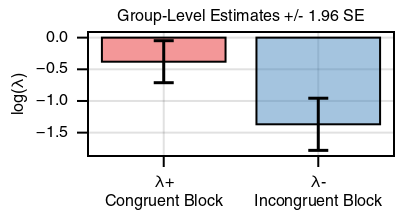

In [19]:
s = "blockwise"
ver = "lrlblockwise_twoλ_BLRL_BBoat_λ1_λ2_aT_islandbias_boatbias_rewscaled_initx"
r = load("../results/$(s)/$(s)_$(ver).jld2")["$(s)_$(ver)"]

colors = categorical_colors(:Set1, 3)
betas = r.betas[end-1:end]
# Get Confidence Intervals
x = [0, 0, 0, 0, 0, 0, 1, 0]
se1 = sqrt(x' * r.covmtx * x)
x = [0, 0, 0, 0, 0, 0, 0, 1]
se2 = sqrt(x' * r.covmtx * x)
ses = [se1; se2]
println("Combined SEs")
println(round.(ses; digits=3))
confints = ses .* 1.96

print("λ1: ")
println(round(betas[1]; digits=3), " +/- ", round(confints[1]; digits=3))
print("λ2: ")
println(round(betas[2]; digits=3), " +/- ", round(confints[2]; digits=3))

diff1 = betas[1] - betas[2]
x = [0, 0, 0, 0, 0, 0, 1, -1]
diff1_se = sqrt(x' * r.covmtx * x)
println("Difference: ", round(diff1; digits=3), " +/- ", round(diff1_se * 1.96; digits=3))
nsub = size(r.x, 1)
nreg = size(r.x, 2)
nparam = size(r.betas,2)
pvals = 2*ccdf(TDist(nparam*(nsub - nreg - 1)), abs(diff1) / diff1_se)
println("t($(nparam*(nsub - nreg - 1))) = $(abs(diff1) / diff1_se)")
println("Diff pvals: ", round(pvals; digits=10))

f = Figure(size=72 .* (2.8, 1.5), fontsize=8)
ax = Axis(f[1, 1],xticks = (1:2, ["λ+\nCongruent Block", "λ-\nIncongruent Block"]),
                ylabel="log(λ)",
                title = "Group-Level Estimates +/- 1.96 SE",
                )
for i in 1:2
        g = barplot!(f[1,1], [i], [betas[i]],
                color=(colors[i], 0.45),
                strokecolor = :black, strokewidth = 1,
        )
end
 # axis = (xticks = (1:2, ["λ+ (Congruent Block)", "λ- (Incongruent Block)"]),
        #         ylabel="log(λ)",
        #         title = "6.2 LRL Blockwise λs (Baseline) +/- 1.96 SE",
        #         ),
errorbars!([1, 2], betas, confints, whiskerwidth = 10, color=:black)
save("figures/blockwise_grouplevel.pdf", f, pt_per_unit=1.0)
f

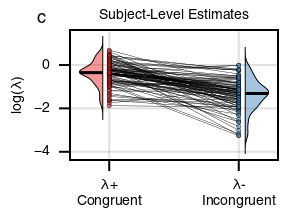

In [18]:
# colors = resample_cmap(:Accent_3, 3)[1:end]
colors = categorical_colors(:Set1, 3)

f = Figure(size=72 .* (2.0, 1.5))
ax = Axis(f[1,1], xticks = (1:2, ["λ+\nCongruent", "λ-\nIncongruent"]),
    ylabel="log(λ)",
    palette = (; patchcolor = colors),
    title = "Subject-Level Estimates",
)
x = repeat([1], inner=100) .- 0.05
violin!(x, r.x[:,7],
        side = :left,
        strokecolor = :black, strokewidth = 0.5,
        color=(colors[1], 0.45),
        width=0.45,
        show_median=true,
        mediancolor=:black,
)
x = repeat([2], inner=100) .+ 0.05
violin!(x, r.x[:,8],
        side = :right,
        strokecolor = :black, strokewidth = 0.5,
        color=(colors[2], 0.45),
        width=0.45,
        show_median=true,
        mediancolor=:black,
)
for i in 1:100
    lines!([1, 2], [r.x[i,7], r.x[i,8]], color=:black, linewidth=0.2)
    scatter!([1], [r.x[i,7]], color=(colors[1], 0.5), strokewidth=0.2, markersize=3)
    scatter!([2], [r.x[i,8]], color=(colors[2], 0.5), strokewidth=0.2, markersize=3)
end
Label(f[1, 1, TopLeft()], "c", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
save("figures/blockwise_subjectlevel.pdf", f, pt_per_unit=1.0)
f